In [2]:
%pip install pyro-ppl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 53.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [57]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoNormal, AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from matplotlib import pyplot as plt
import seaborn as sns

# for reproducibility
torch.manual_seed(42)
pyro.set_rng_seed(42)

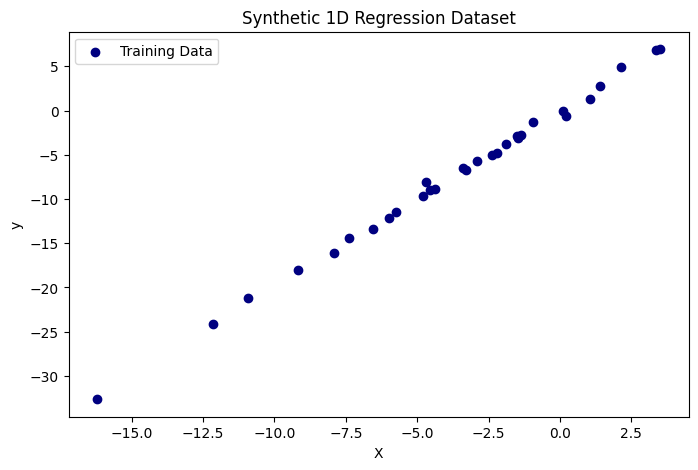

In [64]:
def generate_data(num_points=30):
    X = dist.Normal(-5., 5.).sample(sample_shape=(num_points,))
    y = 2 *X + dist.Normal(0., 0.5).sample(sample_shape=(num_points,))
    return X.unsqueeze(1), y

X_train, y_train = generate_data()

# Let's visualize our data
plt.figure(figsize=(8, 5))
plt.scatter(X_train, y_train, marker='o', color='navy', label="Training Data")
plt.title("Synthetic 1D Regression Dataset")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

In [65]:
class BayesianNet(PyroModule):
    def __init__(self, in_features, out_features, hidden_features=64):
        super().__init__()

        # Define the structure of the network
        #self.fc1 = PyroModule[nn.Linear](in_features, hidden_features)
        #self.fc2 = PyroModule[nn.Linear](hidden_features, hidden_features)
        self.fc3 = PyroModule[nn.Linear](in_features, out_features)

        # Define priors for the weights and biases.
        # A Normal(0, 1) prior is a common choice.
        #self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([hidden_features, in_features]).to_event(2))
        #self.fc1.bias = PyroSample(dist.Normal(0., 1.).expand([hidden_features]).to_event(1))

        #self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([hidden_features, hidden_features]).to_event(2))
        #self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([hidden_features]).to_event(1))

        self.fc3.weight = PyroSample(dist.Normal(0., 1.).expand([in_features, out_features]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0., 1.).expand([out_features]).to_event(1))

        self.relu = nn.ReLU()

    def forward(self, x, y=None):
        #x = self.relu(self.fc1(x))
        #x = self.relu(self.fc2(x))

        # The output of the network is the mean of our predictive distribution
        mu = self.fc3(x).squeeze()

        # We model the observation noise as a learnable parameter
        sigma = pyro.param("sigma", torch.tensor(1.0), constraint=dist.constraints.positive)

        # The likelihood function: we assume our data is normally distributed around the mean `mu`
        # This is where we connect the model to the observed data `y`
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y)

        return mu


In [66]:
# Instantiate our BNN
net = BayesianNet(in_features=1, out_features=1)
guide = AutoMultivariateNormal(net)

In [67]:
# Setup the optimizer
adam = pyro.optim.Adam({"lr": 0.001})

# Setup the inference algorithm
svi = SVI(net, guide, adam, loss=Trace_ELBO())

# Training loop
pyro.clear_param_store()
num_iterations = 10000
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(X_train, y_train)

    if j % 500 == 0:
        print(f"[iteration {j+1:04d}] loss: {loss / len(X_train):.4f}")

print("Training finished!")

[iteration 0001] loss: 92.5726
[iteration 0501] loss: 27.2494
[iteration 1001] loss: 13.8583
[iteration 1501] loss: 8.1172
[iteration 2001] loss: 5.8635
[iteration 2501] loss: 4.1631
[iteration 3001] loss: 3.3050
[iteration 3501] loss: 3.0019
[iteration 4001] loss: 2.7614
[iteration 4501] loss: 2.3275
[iteration 5001] loss: 2.2123
[iteration 5501] loss: 2.4133
[iteration 6001] loss: 2.0547
[iteration 6501] loss: 1.9046
[iteration 7001] loss: 1.7981
[iteration 7501] loss: 1.7404
[iteration 8001] loss: 1.5267
[iteration 8501] loss: 1.3483
[iteration 9001] loss: 1.1328
[iteration 9501] loss: 1.0004
Training finished!


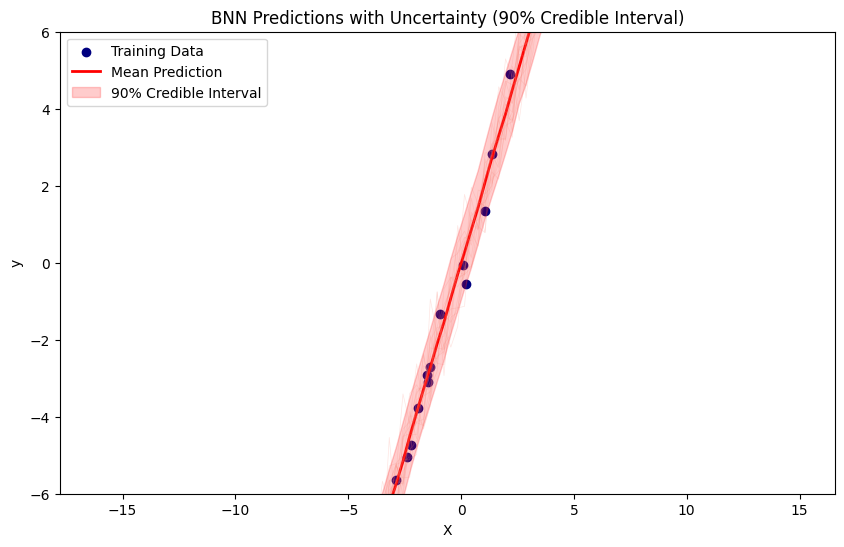

In [68]:
from pyro.infer import Predictive
import matplotlib.pyplot as plt
import torch

# 1. Create a grid of x-values to test the model on
X_test = torch.linspace(-15, 15, 100).unsqueeze(1)

# 2. Sample from the posterior using Predictive
predictive = Predictive(net, guide=guide, num_samples=1000)
svi_samples = predictive(X_test)

# 3. Extract predicted y-values (obs)
y_samples = svi_samples["obs"]  # shape: [num_samples, 100]

# 4. Compute mean prediction and 90% credible interval
predictions_mean = y_samples.mean(dim=0)
lower_bound = y_samples.quantile(0.05, dim=0)
upper_bound = y_samples.quantile(0.95, dim=0)

# ---- 5. Visualization ----
plt.figure(figsize=(10, 6))

# Plot training data
plt.scatter(X_train, y_train, marker='o', color='navy', label="Training Data")

# Plot mean prediction
plt.plot(X_test, predictions_mean.detach().numpy(), color='red', lw=2, label="Mean Prediction")

# Plot 90% credible interval
plt.fill_between(
    X_test.squeeze().numpy(),
    lower_bound.detach().numpy(),
    upper_bound.detach().numpy(),
    color='red',
    alpha=0.2,
    label="90% Credible Interval"
)

# Plot a few sample prediction curves to visualize posterior variability
for i in range(20):
    plt.plot(X_test, y_samples[i].detach().numpy(), color='salmon', alpha=0.2, lw=0.5)

plt.title("BNN Predictions with Uncertainty (90% Credible Interval)")
plt.xlabel("X")
plt.ylabel("y")
plt.ylim(-6, 6)
plt.legend(loc='upper left')
plt.show()


In [70]:
from pyro.infer import MCMC, NUTS


nuts_kernel = NUTS(net)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(X_train, y_train)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

Sample: 100%|██████████| 1200/1200 [00:19, 60.93it/s, step size=5.63e-01, acc. prob=0.919]
